# Environment Setup & Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/ens492/ISIC_2019_Training_Input.zip' -d /content/train_dataset
!unzip '/content/drive/My Drive/ens492/ISIC_2019_Test_Input.zip' -d /content/test_dataset

!pip install focal-loss-torch

!pip install ipywidgets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/ens492/ISIC_2019_Training_Input.zip
Archive:  /content/drive/My Drive/ens492/ISIC_2019_Test_Input.zip
replace /content/test_dataset/ISIC_2019_Test_Input/ATTRIBUTION.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: focal-loss-torch in /usr/local/lib/python3.11/dist-packages (0.1.2)


In [ ]:
!pip install ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 26.9 MB/s eta 0:00:00


In [ ]:
!pip install mamba_ssm --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mamba_ssm: filename=mamba_ssm-2.2.4-cp311-cp311-linux_x86_64.whl size=323672993 sha256=8a0be01153fa30727a9e69024fbe061eb92c7ba4416d2049c5fc3107ed91d852
  Stored in directory: /root/.cache/pip/wheels/2a/5e/64/cfcb5dfe4f854944456e031c34953dc872af1ad7c206145d4a
Successfully built mamba_ssm


In [ ]:
# General Libraries
import os
import sys
import numpy as np
import pandas as pd
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import torchvision.transforms.functional as TF
from collections import Counter

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# PyTorch Vision Libraries
import torchvision.utils
from torchvision import models, datasets, transforms

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Additional Libraries
import timm
from tqdm import tqdm
from focal_loss.focal_loss import FocalLoss

# Visualization
%matplotlib inline


# Preprocessing

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Random Seed Set
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# If using CUDA, ensure deterministic behavior as well
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # for multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data paths
data_dir = '/content/drive/MyDrive/ens492'
train_dir = '/content/train_dataset/ISIC_2019_Training_Input'
test_dir = '/content/test_dataset/ISIC_2019_Test_Input'
train_ground_truth = 'ISIC_2019_Training_GroundTruth.csv'
test_ground_truth = 'ISIC_2019_Test_GroundTruth.csv'
# Load and process ground truth
train_ground_truth_df = pd.read_csv(os.path.join(data_dir, train_ground_truth))
test_ground_truth_df = pd.read_csv(os.path.join(data_dir, test_ground_truth))

# Process training data - exclude 'image' column and create single_label
train_labels = train_ground_truth_df.iloc[:, 1:9]  # Exclude 'image' and 'UNK' columns
train_ground_truth_df['single_label'] = train_labels.values.argmax(axis=1)

# Process test data - exclude 'image', 'score_weight', and 'validation_weight' columns
test_labels = test_ground_truth_df.iloc[:, 1:10]  # Include UNK class
test_ground_truth_df['single_label'] = test_labels.values.argmax(axis=1)

# Ensure patient ID-based stratification to avoid data leakage
train_ground_truth_df['patient_id'] = train_ground_truth_df['image']

# Stratified split by patient ID
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Generate train/val indices
for train_idx, val_idx in sgkf.split(train_ground_truth_df, train_ground_truth_df['single_label'], groups=train_ground_truth_df['patient_id']):
    train_df = train_ground_truth_df.iloc[train_idx].reset_index(drop=True)
    val_df = train_ground_truth_df.iloc[val_idx].reset_index(drop=True)
    break  # Take the first fold as train/val split

# Drop patient_id column as it's no longer needed
train_df = train_df.drop(columns=['patient_id'])
val_df = val_df.drop(columns=['patient_id'])

# Augmentations
class CircularMask:
    def __call__(self, image):
        w, h = image.size
        # Create mask
        mask = Image.new("L", (w, h), 0)
        draw = ImageDraw.Draw(mask)
        # Draw white circle in the center (adjust scale here if needed)
        radius = min(w, h) // 2
        draw.ellipse((w//2 - radius, h//2 - radius, w//2 + radius, h//2 + radius), fill=255)

        # Convert image to RGBA for masking
        image = image.convert("RGBA")
        black_bg = Image.new("RGBA", image.size, (0, 0, 0, 255))
        image = Image.composite(image, black_bg, mask)

        # Convert back to RGB
        return image.convert("RGB")

class CenterSquareCrop:
    def __call__(self, image):
        w, h = image.size
        min_dim = min(w, h)
        left = (w - min_dim) // 2
        top = (h - min_dim) // 2
        right = left + min_dim
        bottom = top + min_dim
        return image.crop((left, top, right, bottom))


train_transform = transforms.Compose([
    CenterSquareCrop(),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.RandomRotation(degrees=45), # was 90
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=0.5,
            translate=(0.1, 0.1),
            scale=(1.0, 1.05),
            fill=(200, 200, 200)
        )
    ], p=0.5),


    transforms.RandomAffine(degrees=0.5, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # slightly more conservative
    #CircularMask(),  # custom transform here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomErasing(
        p=0.5,
        scale=(16*16 / (224*224), 16*16 / (224*224)),
        ratio=(1.0, 1.0),
        value='random'
    ),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    CenterSquareCrop(),  # or CenterSquareCrop
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Modify the dataset class to handle both training and test data
class ISICDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image'] + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)

        if self.is_test:
            # For test data, include UNK class
            label_cols = self.dataframe.iloc[:, 1:10]  # MEL to UNK
        else:
            # For training data, exclude UNK class
            label_cols = self.dataframe.iloc[:, 1:9]  # MEL to SCC

        label = self.dataframe.iloc[idx]['single_label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
BATCH_SIZE = 16
train_dataset = ISICDataset(train_df, train_dir, train_transform, is_test=False)
val_dataset = ISICDataset(val_df, train_dir, val_transform, is_test=False)
test_dataset = ISICDataset(test_ground_truth_df, test_dir, val_transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Augmentation Results:

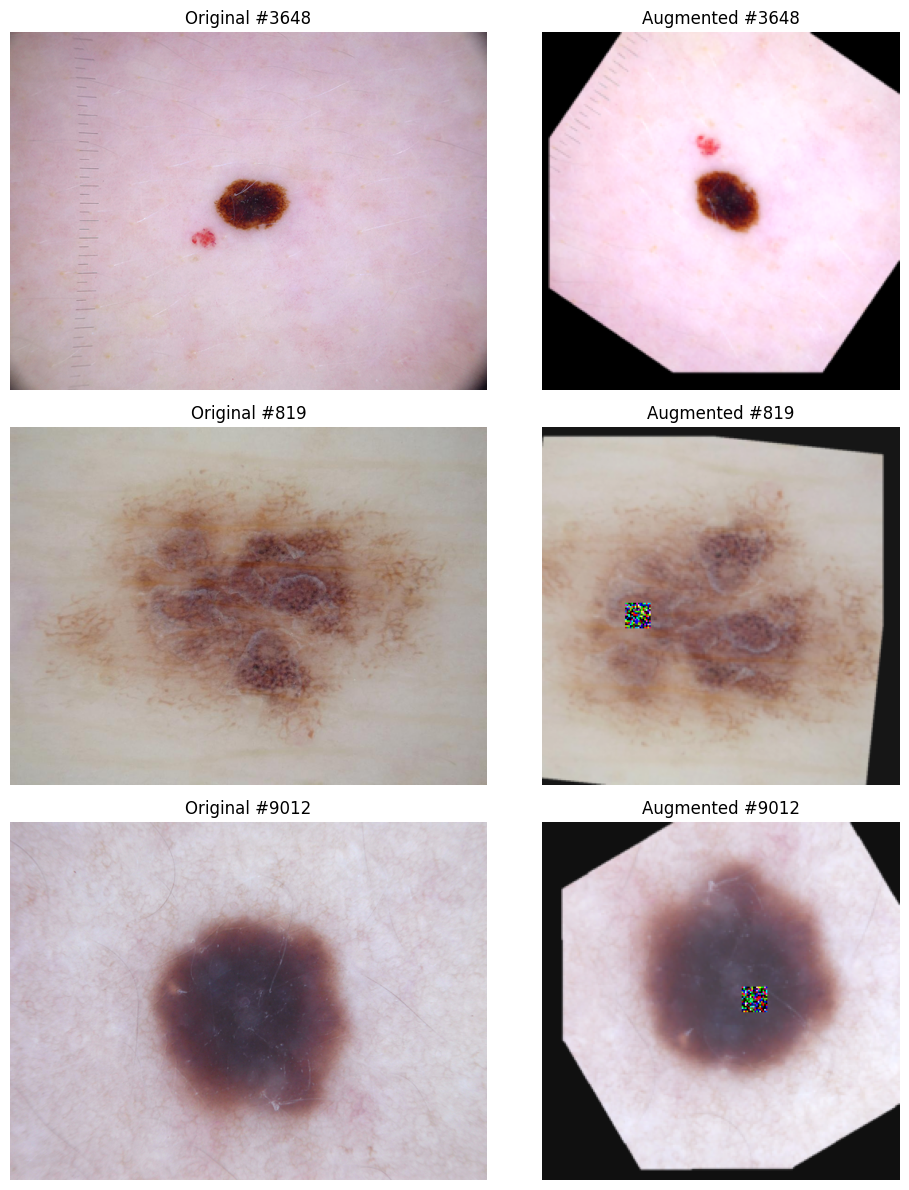

In [ ]:
# Helper to undo normalization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return torch.clamp(tensor * std[:, None, None] + mean[:, None, None], 0, 1)

# Pick 3 random indices from the train_df
sample_indices = random.sample(range(len(train_df)), 3)

# Create figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for row, idx in enumerate(sample_indices):
    img_name = train_df.iloc[idx]['image'] + '.jpg'
    img_path = os.path.join(train_dir, img_name)

    # Load original
    original_image = Image.open(img_path).convert("RGB")

    # Augmented version
    augmented_tensor = train_transform(original_image)
    augmented_image = denormalize(augmented_tensor)
    augmented_image = TF.to_pil_image(augmented_image)

    # Plot original
    axes[row, 0].imshow(original_image)
    axes[row, 0].set_title(f'Original #{idx}')
    axes[row, 0].axis('off')

    # Plot augmented
    axes[row, 1].imshow(augmented_image)
    axes[row, 1].set_title(f'Augmented #{idx}')
    axes[row, 1].axis('off')

plt.tight_layout()
plt.show()


# HYPERPARAMETER TUNING w/Bayesian Optimization


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from transformers import AutoModelForImageClassification

def extract_logits(outputs):
    return outputs.logits if hasattr(outputs, "logits") else outputs["logits"]

def evaluate(model, dataloader, criterion, use_focal: bool):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            logits  = extract_logits(outputs)

            if use_focal:
                probs = torch.softmax(logits, dim=-1)
                loss  = criterion(probs, targets)
                preds = probs.argmax(dim=1)
            else:
                loss  = criterion(logits, targets)
                preds = logits.softmax(dim=-1).argmax(dim=1)

            total_loss += loss.item() * targets.size(0)
            correct    += preds.eq(targets).sum().item()
            total      += targets.size(0)
            all_preds .extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = total_loss / total
    acc      = 100. * correct / total
    f1       = f1_score(all_labels, all_preds, average='macro')
    return acc, avg_loss, f1



# — Optuna objective ——————————————————————————————————————

def objective(trial):
    # Optimizer choice
    opt_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "AdamW"])
    if opt_name == "SGD":
        lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    else:
        lr = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    wd = trial.suggest_float("weight_decay", 1e-4, 5e-3, log=True)
    ga = trial.suggest_categorical("grad_accumulation", [1, 2, 4])

    # Loss function choice
    loss_choice = trial.suggest_categorical("loss_fn", ["cross_entropy", "focal"])
    use_focal   = (loss_choice == "focal")
    if use_focal:
        criterion = FocalLoss(gamma=2.0)       # expects probabilities
    else:
        criterion = nn.CrossEntropyLoss()       # expects logits

    # Model + optimizer setup
    model = AutoModelForImageClassification.from_pretrained(
        "nvidia/MambaVision-B-21K", trust_remote_code=True
    ).to(device)
    if opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif opt_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    scaler = GradScaler()
    best_val_loss = float('inf')
    n_epochs = 3

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        running_loss, correct, total = 0.0, 0, 0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast():
                outputs = model(inputs)
                logits  = extract_logits(outputs)

                if use_focal:
                    probs = torch.softmax(logits, dim=-1)
                    loss  = criterion(probs, targets) / ga
                    preds = probs.argmax(dim=1)
                else:
                    loss  = criterion(logits, targets) / ga
                    preds = logits.softmax(dim=-1).argmax(dim=1)

            scaler.scale(loss).backward()
            if (i + 1) % ga == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * targets.size(0) * ga
            with torch.no_grad():
                correct += preds.eq(targets).sum().item()
                total   += targets.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc  = 100. * correct / total

        val_acc, val_loss, val_f1 = evaluate(model, val_loader, criterion, use_focal)

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        best_val_loss = min(best_val_loss, val_loss)
        print(f"[{opt_name:^5} | {loss_choice:^13}] "
              f"Epoch {epoch+1}/{n_epochs}   "
              f"Train: {train_acc:5.1f}%/{train_loss:.4f}   "
              f"Val: {val_acc:5.1f}%/{val_loss:.4f}   F1: {val_f1:.4f}")

    return best_val_loss


def run_hyperparameter_tuning(n_trials=20):
    study = optuna.create_study(
        direction="minimize",
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    study.optimize(objective, n_trials=n_trials)

    print("Best trial:")
    print(" Value: ", study.best_value)
    print(" Params:")
    for k, v in study.best_trial.params.items():
        print(f"  {k}: {v}")
    return study.best_trial.params


    # Plot optimization history
    plt.figure(figsize=(12, 8))

    # Plot optimization history
    plt.subplot(2, 2, 1)
    optuna.visualization.matplotlib.plot_optimization_history(study)

    # Plot parameter importances
    plt.subplot(2, 2, 2)
    optuna.visualization.matplotlib.plot_param_importances(study)

    # Plot parallel coordinate
    plt.subplot(2, 2, 3)
    optuna.visualization.matplotlib.plot_parallel_coordinate(study)

    # Plot slice
    plt.subplot(2, 2, 4)
    optuna.visualization.matplotlib.plot_slice(study)

    plt.tight_layout()
    plt.savefig('hyperparameter_tuning_results.png')
    plt.show()

    return trial.params


# Main execution flow
if __name__ == "__main__":
    # Set number of trials based on computational resources
    n_trials = 10  # Adjust based on constraints

    # Run hyperparameter tuning
    print(f"Running hyperparameter tuning with {n_trials} trials...")
    best_params = run_hyperparameter_tuning(n_trials=n_trials)


[I 2025-04-27 12:16:07,210] A new study created in memory with name: no-name-79411000-acff-4e63-83d9-377068f43152


Running hyperparameter tuning with 10 trials...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/768 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-B-21K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py:   0%|          | 0.00/29.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-B-21K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/391M [00:00<?, ?B/s]

<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 1/3   Train:   0.0%/7.2859   Val:   0.0%/7.3845   F1: 0.0000


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 2/3   Train:   0.3%/6.8696   Val:   0.2%/7.0179   F1: 0.0001


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 12:22:53,327] Trial 0 finished with value: 6.4052942809124875 and parameters: {'optimizer': 'AdamW', 'learning_rate': 1.9804943156162683e-06, 'weight_decay': 0.0018534565487527107, 'grad_accumulation': 4, 'loss_fn': 'cross_entropy'}. Best is trial 0 with value: 6.4052942809124875.


[AdamW | cross_entropy] Epoch 3/3   Train:   6.5%/6.4075   Val:  11.2%/6.4053   F1: 0.0023


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 1/3   Train:  42.8%/4.3154   Val:  65.9%/2.3258   F1: 0.1339


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 2/3   Train:  66.9%/2.2721   Val:  69.2%/1.8359   F1: 0.4375


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 12:29:32,468] Trial 1 finished with value: 1.429605018796066 and parameters: {'optimizer': 'AdamW', 'learning_rate': 1.056522527036038e-05, 'weight_decay': 0.000188074428592256, 'grad_accumulation': 1, 'loss_fn': 'cross_entropy'}. Best is trial 1 with value: 1.429605018796066.


[AdamW | cross_entropy] Epoch 3/3   Train:  70.1%/1.8210   Val:  72.0%/1.4296   F1: 0.4590


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Adam  | cross_entropy] Epoch 1/3   Train:   0.2%/7.0269   Val:   0.6%/6.8923   F1: 0.0003


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Adam  | cross_entropy] Epoch 2/3   Train:  22.7%/5.7266   Val:  44.2%/4.4028   F1: 0.0134


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 12:36:10,327] Trial 2 finished with value: 3.08816639971366 and parameters: {'optimizer': 'Adam', 'learning_rate': 9.475249022790019e-06, 'weight_decay': 0.004104176117260893, 'grad_accumulation': 4, 'loss_fn': 'cross_entropy'}. Best is trial 1 with value: 1.429605018796066.


[Adam  | cross_entropy] Epoch 3/3   Train:  52.3%/3.8756   Val:  59.8%/3.0882   F1: 0.0505


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[ SGD  |     focal    ] Epoch 1/3   Train:  60.6%/1.4901   Val:  70.5%/0.5117   F1: 0.4195


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[ SGD  |     focal    ] Epoch 2/3   Train:  69.5%/0.4860   Val:  72.6%/0.4162   F1: 0.4999


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 12:42:48,533] Trial 3 finished with value: 0.3859336268417081 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.013863594168643724, 'weight_decay': 0.001137973987900207, 'grad_accumulation': 2, 'loss_fn': 'focal'}. Best is trial 3 with value: 0.3859336268417081.


[ SGD  |     focal    ] Epoch 3/3   Train:  72.2%/0.4207   Val:  74.7%/0.3859   F1: 0.5731


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 1/3   Train:  38.4%/4.6577   Val:  64.0%/2.5480   F1: 0.0982


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 2/3   Train:  65.4%/2.4751   Val:  68.8%/1.9111   F1: 0.3068


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 12:49:25,381] Trial 4 finished with value: 1.5932480177293875 and parameters: {'optimizer': 'AdamW', 'learning_rate': 8.664141907415596e-06, 'weight_decay': 0.00017376793753312892, 'grad_accumulation': 1, 'loss_fn': 'cross_entropy'}. Best is trial 3 with value: 0.3859336268417081.


[AdamW | cross_entropy] Epoch 3/3   Train:  69.0%/1.9456   Val:  70.8%/1.5932   F1: 0.4513


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 1/3   Train:  26.7%/5.4275   Val:  60.5%/3.0418   F1: 0.0468


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 2/3   Train:  63.2%/2.8447   Val:  67.8%/2.0612   F1: 0.2094


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 12:56:05,361] Trial 5 finished with value: 1.8292050494349525 and parameters: {'optimizer': 'AdamW', 'learning_rate': 9.564070917090473e-06, 'weight_decay': 0.0017229948458807737, 'grad_accumulation': 2, 'loss_fn': 'cross_entropy'}. Best is trial 3 with value: 0.3859336268417081.


[AdamW | cross_entropy] Epoch 3/3   Train:  66.9%/2.2644   Val:  69.0%/1.8292   F1: 0.3836


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW |     focal    ] Epoch 1/3   Train:  55.4%/3.0272   Val:  70.3%/1.3299   F1: 0.4559


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW |     focal    ] Epoch 2/3   Train:  69.2%/1.3056   Val:  74.6%/0.8367   F1: 0.5328


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 13:02:42,106] Trial 6 finished with value: 0.7083338003265872 and parameters: {'optimizer': 'AdamW', 'learning_rate': 4.56357114497562e-05, 'weight_decay': 0.0004859975169051876, 'grad_accumulation': 2, 'loss_fn': 'focal'}. Best is trial 3 with value: 0.3859336268417081.


[AdamW |     focal    ] Epoch 3/3   Train:  70.9%/0.9702   Val:  76.1%/0.7083   F1: 0.5763


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[ SGD  | cross_entropy] Epoch 1/3   Train:  62.8%/1.4378   Val:  69.7%/0.8253   F1: 0.4487


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[ SGD  | cross_entropy] Epoch 2/3   Train:  70.9%/0.8015   Val:  73.0%/0.7264   F1: 0.5225


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 13:09:21,518] Trial 7 finished with value: 0.6926010844973862 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.014251319046072325, 'weight_decay': 0.00011260824799460134, 'grad_accumulation': 1, 'loss_fn': 'cross_entropy'}. Best is trial 3 with value: 0.3859336268417081.


[ SGD  | cross_entropy] Epoch 3/3   Train:  73.4%/0.7282   Val:  75.3%/0.6926   F1: 0.5863


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[ SGD  |     focal    ] Epoch 1/3   Train:  53.2%/2.8688   Val:  68.4%/0.9920   F1: 0.3892


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[ SGD  |     focal    ] Epoch 2/3   Train:  66.8%/0.8152   Val:  71.8%/0.5471   F1: 0.4710


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 13:15:59,876] Trial 8 finished with value: 0.4547129084223398 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.007179689872516802, 'weight_decay': 0.0031464011376885286, 'grad_accumulation': 4, 'loss_fn': 'focal'}. Best is trial 3 with value: 0.3859336268417081.


[ SGD  |     focal    ] Epoch 3/3   Train:  69.3%/0.5427   Val:  73.6%/0.4547   F1: 0.5307


<ipython-input-8-3fccb2b575c3>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 1/3   Train:   5.0%/6.6977   Val:  25.4%/5.5743   F1: 0.0050


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[AdamW | cross_entropy] Epoch 2/3   Train:  47.4%/4.2540   Val:  58.6%/3.1654   F1: 0.0458


<ipython-input-8-3fccb2b575c3>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-04-27 13:22:38,326] Trial 9 finished with value: 2.703027863489325 and parameters: {'optimizer': 'AdamW', 'learning_rate': 2.5522052487005817e-06, 'weight_decay': 0.004702144400462364, 'grad_accumulation': 1, 'loss_fn': 'cross_entropy'}. Best is trial 3 with value: 0.3859336268417081.


[AdamW | cross_entropy] Epoch 3/3   Train:  60.1%/3.1456   Val:  63.0%/2.7030   F1: 0.0885
Best trial:
 Value:  0.3859336268417081
 Params:
  optimizer: SGD
  learning_rate: 0.013863594168643724
  weight_decay: 0.001137973987900207
  grad_accumulation: 2
  loss_fn: focal


In [ ]:
best_params

{'optimizer': 'SGD',
 'learning_rate': 0.013863594168643724,
 'weight_decay': 0.001137973987900207,
 'grad_accumulation': 2,
 'loss_fn': 'focal'}

 # Training and Testing the Best Set of Hyperparameters (w/SGD)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from tqdm.auto import tqdm
from transformers import AutoModelForImageClassification

# === Hyperparams ===
# best_params dict
best_params = {
    'optimizer': 'SGD',
    'learning_rate': 0.013863594168643724,
    'weight_decay': 0.001137973987900207,
    'grad_accumulation': 2,
    'loss_fn': 'focal'
}

lr               = best_params['learning_rate']
wd               = best_params['weight_decay']
grad_accum       = best_params['grad_accumulation']
use_focal        = (best_params['loss_fn'] == 'focal')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()   # just use defaults

# === Model & Criterion ===

model = AutoModelForImageClassification.from_pretrained(
    "nvidia/MambaVision-B-21K",
    trust_remote_code=True
).to(device)

if use_focal:
    # expects probabilities in [0,1]
    criterion = FocalLoss(gamma=2.0, reduction='mean')
else:
    criterion = nn.CrossEntropyLoss()

# === Optimizer ===

if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=wd
    )
elif best_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
else:
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# === AMP Scaler ===
scaler = GradScaler()   # just use defaults

# === Training & Eval Functions ===

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    total_loss = correct = total = 0

    for step, (inputs, targets) in enumerate(tqdm(dataloader, desc="Train")):
        inputs, targets = inputs.to(device), targets.to(device)
        with autocast(device_type=device.type):
            outputs = model(inputs)
            logits  = extract_logits(outputs)

            if use_focal:
                probs = torch.softmax(logits, dim=-1)
                loss  = criterion(probs, targets) / grad_accum
                preds = probs.argmax(dim=1)
            else:
                loss  = criterion(logits, targets) / grad_accum
                preds = logits.softmax(dim=-1).argmax(dim=1)

        scaler.scale(loss).backward()

        if (step + 1) % grad_accum == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        batch_size = targets.size(0)
        total_loss += loss.item() * grad_accum * batch_size
        correct    += preds.eq(targets).sum().item()
        total      += batch_size

    return 100. * correct/total, total_loss/total


def evaluate(model, dataloader, criterion, is_test=False):
    model.eval()
    total_loss = correct = total = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Eval"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            logits  = extract_logits(outputs)

            if use_focal:
                probs = torch.softmax(logits, dim=-1)
                loss  = criterion(probs, targets)
                preds = probs.argmax(dim=1)
            else:
                loss  = criterion(logits, targets)
                probs = logits.softmax(dim=-1)
                preds = probs.argmax(dim=1)

            total_loss += loss.item() * targets.size(0)

            if is_test:
                max_probs = probs.max(1).values
                unk_mask  = (1 - max_probs) > 0.5
                preds     = torch.where(
                    unk_mask,
                    torch.full_like(preds, model.config.num_labels-1),
                    preds
                )

            correct += preds.eq(targets).sum().item()
            total   += targets.size(0)
            all_preds .extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_probs .extend(probs.cpu().numpy())

    avg_loss = total_loss / total
    acc      = 100. * correct / total
    f1       = f1_score(all_labels, all_preds, average='macro')
    return acc, avg_loss, f1, all_preds, all_labels, all_probs

# === Training Loop ===

num_epochs     = 15
best_val_loss  = float('inf')
train_accs     = []; val_accs = []
train_losses   = []; val_losses = []; val_f1s = []

print("Starting training with best_params:", best_params)
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tr_acc, tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_acc, va_loss, va_f1, *_ = evaluate(model, val_loader, criterion)

    train_accs .append(tr_acc)
    val_accs   .append(va_acc)
    train_losses.append(tr_loss)
    val_losses .append(va_loss)
    val_f1s     .append(va_f1)

    print(f"Train → Acc: {tr_acc:.2f}%, Loss: {tr_loss:.4f}")
    print(f"Val   → Acc: {va_acc:.2f}%, Loss: {va_loss:.4f}, F1: {va_f1:.4f}")

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(model.state_dict(), 'best_vmamba_model_lowest_loss.pth')
        print(f"✅ Saved checkpoint (val loss: {best_val_loss:.4f})")


Starting training with best_params: {'optimizer': 'SGD', 'learning_rate': 0.013863594168643724, 'weight_decay': 0.001137973987900207, 'grad_accumulation': 2, 'loss_fn': 'focal'}

Epoch 1/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 59.20%, Loss: 1.5452
Val   → Acc: 68.97%, Loss: 0.5236, F1: 0.4465
✅ Saved checkpoint (val loss: 0.5236)

Epoch 2/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 69.53%, Loss: 0.4787
Val   → Acc: 73.45%, Loss: 0.4087, F1: 0.5162
✅ Saved checkpoint (val loss: 0.4087)

Epoch 3/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 71.56%, Loss: 0.4194
Val   → Acc: 72.11%, Loss: 0.4043, F1: 0.5725
✅ Saved checkpoint (val loss: 0.4043)

Epoch 4/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 73.49%, Loss: 0.3877
Val   → Acc: 75.27%, Loss: 0.3563, F1: 0.6037
✅ Saved checkpoint (val loss: 0.3563)

Epoch 5/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 74.60%, Loss: 0.3622
Val   → Acc: 76.00%, Loss: 0.3381, F1: 0.6083
✅ Saved checkpoint (val loss: 0.3381)

Epoch 6/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 75.85%, Loss: 0.3422
Val   → Acc: 75.19%, Loss: 0.3409, F1: 0.6290

Epoch 7/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 76.59%, Loss: 0.3250
Val   → Acc: 76.55%, Loss: 0.3387, F1: 0.5881

Epoch 8/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 77.05%, Loss: 0.3103
Val   → Acc: 77.65%, Loss: 0.3013, F1: 0.6510
✅ Saved checkpoint (val loss: 0.3013)

Epoch 9/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 77.94%, Loss: 0.2959
Val   → Acc: 78.05%, Loss: 0.2955, F1: 0.6593
✅ Saved checkpoint (val loss: 0.2955)

Epoch 10/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 78.81%, Loss: 0.2805
Val   → Acc: 79.79%, Loss: 0.2817, F1: 0.6851
✅ Saved checkpoint (val loss: 0.2817)

Epoch 11/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20> 
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     ^<function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

^    Traceback (most recent call last):
if w.is_alive():^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py"

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 79.08%, Loss: 0.2776
Val   → Acc: 79.45%, Loss: 0.2895, F1: 0.6745

Epoch 12/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 79.58%, Loss: 0.2629
Val   → Acc: 79.73%, Loss: 0.2798, F1: 0.6923
✅ Saved checkpoint (val loss: 0.2798)

Epoch 13/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 80.49%, Loss: 0.2565
Val   → Acc: 80.36%, Loss: 0.2682, F1: 0.6920
✅ Saved checkpoint (val loss: 0.2682)

Epoch 14/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 80.28%, Loss: 0.2485
Val   → Acc: 81.27%, Loss: 0.2556, F1: 0.7075
✅ Saved checkpoint (val loss: 0.2556)

Epoch 15/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x799b8eed4c20>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^^    ^self._shutdown_workers()^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^^
 ^ ^ ^  ^

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 81.42%, Loss: 0.2351
Val   → Acc: 79.51%, Loss: 0.2747, F1: 0.6708


highest validation accuracy over 15 epochs: 0.8127

## Last Training with Val + Train:

In [ ]:
# === Combine the Training and Validation Data ===
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])  # Combine train and val datasets
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# === Fine-Tune on Combined Dataset ===
num_fine_tune_epochs = 5  # Fine-tune for a few epochs with the combined dataset
for epoch in range(num_fine_tune_epochs):
    print(f'\nFine-tuning Epoch [{epoch+1}/{num_fine_tune_epochs}]')
    train_acc, train_loss = train_one_epoch(model, combined_loader, optimizer, criterion=FocalLoss(gamma=2.0, reduction='mean'))
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Train Loss: {train_loss:.4f}')

torch.save(model.state_dict(), 'best_vmamba_model_after_val.pth')
# print(f'✅ Model saved! Best Macro F1: {best_val_f1:.4f}')


Fine-tuning Epoch [1/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 80.40%
Train Loss: 0.2544

Fine-tuning Epoch [2/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 81.69%
Train Loss: 0.2347

Fine-tuning Epoch [3/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 82.24%
Train Loss: 0.2240

Fine-tuning Epoch [4/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 82.25%
Train Loss: 0.2193

Fine-tuning Epoch [5/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 82.56%
Train Loss: 0.2099


## Testing after last training with combined dataset:


Evaluating on test set (ignoring UNK class)...
Test Accuracy (excluding UNK): 72.27%
F1 Score (excluding UNK): 0.7097


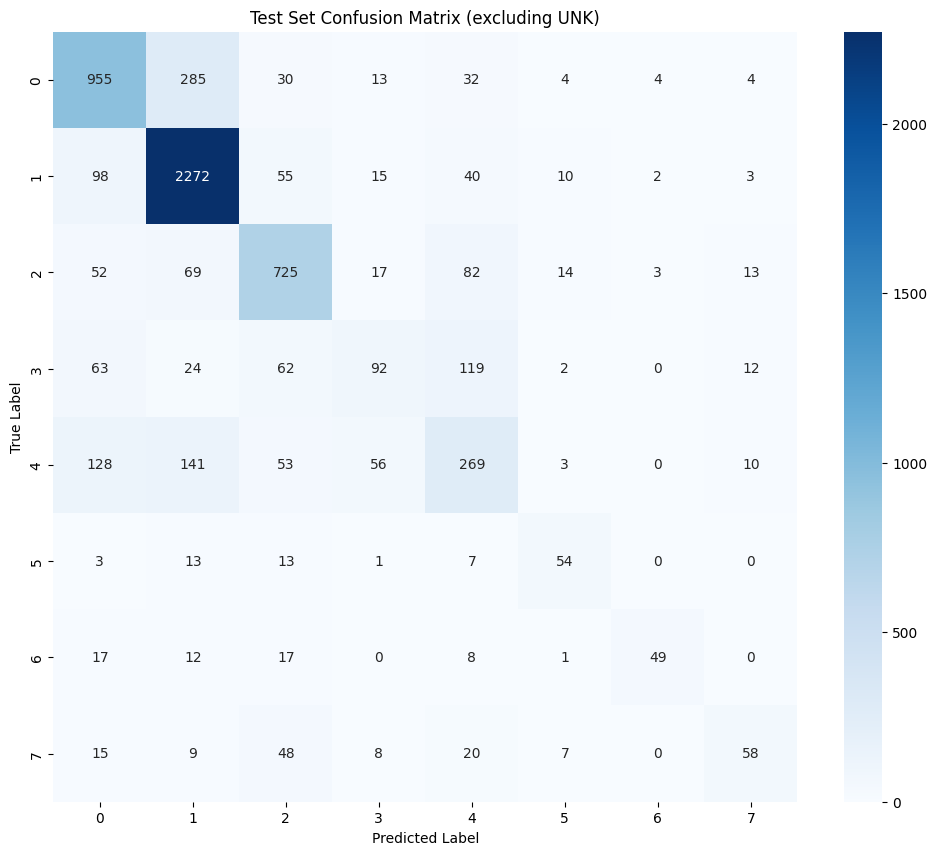

Displaying first 1717 misclassified images:


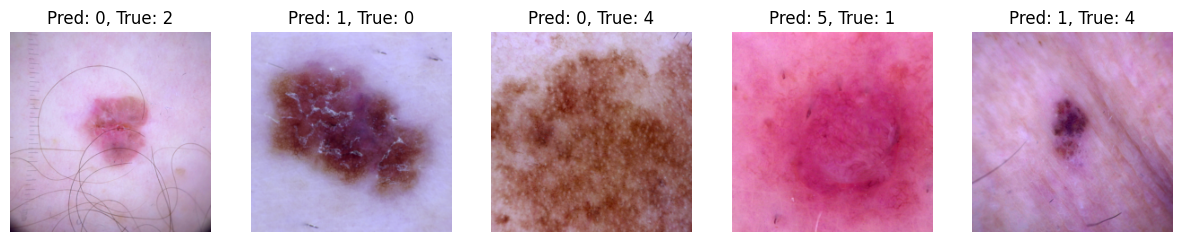

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the trained model
model.load_state_dict(torch.load('best_vmamba_model_after_val.pth'))

def evaluate_ignore_unk(model, dataloader):
    """
    Evaluates the model on test set, ignoring samples that are labeled as UNK class.
    Works with a model trained on 9 classes but only evaluates on the first 8 classes.
    """
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    all_probs = []
    misclassified_images = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Skip samples labeled as UNK (class 8)
            mask = targets != 8
            if not mask.any():
                continue

            # Filter out UNK samples
            filtered_inputs = inputs[mask]
            filtered_targets = targets[mask]

            if len(filtered_inputs) == 0:
                continue

            outputs = model(filtered_inputs)
            # Extract logits from the model output dictionary
            logits = outputs.logits if hasattr(outputs, "logits") else outputs["logits"]
            probs = torch.softmax(logits, dim=-1)

            # Only consider probabilities for known classes (0-7)
            known_probs = probs[:, :8]
            _, predicted = known_probs.max(1)

            correct += predicted.eq(filtered_targets).sum().item()
            total += filtered_targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(filtered_targets.cpu().numpy())
            all_probs.extend(known_probs.cpu().numpy())

            # Collect misclassified images for visualization
            for i in range(len(filtered_targets)):
                if predicted[i] != filtered_targets[i]:
                    misclassified_images.append((filtered_inputs[i].cpu(), predicted[i].cpu(), filtered_targets[i].cpu()))

    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy, all_preds, all_labels, all_probs, misclassified_images

# After training loop, evaluate ignoring UNK class
print("\nEvaluating on test set (ignoring UNK class)...")
test_acc, test_preds, test_labels, test_probs, misclassified_images = evaluate_ignore_unk(model, test_loader)
print(f'Test Accuracy (excluding UNK): {test_acc:.2f}%')

# Calculate F1 Score (using weighted average)
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'F1 Score (excluding UNK): {f1:.4f}')

# Calculate and display confusion matrix for test set (8 classes)
cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix (excluding UNK)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display some misclassified images
print(f"Displaying first {len(misclassified_images)} misclassified images:")
num_images = 5  # Change this to display more or fewer images
plt.figure(figsize=(15, 10))

for i, (image, pred, true) in enumerate(misclassified_images[:num_images]):
    plt.subplot(1, num_images, i + 1)

    # If the image tensor is in format [C, H, W], permute it to [H, W, C]
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format (if necessary)

    # Ensure the image is in the right range for plotting
    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

    plt.imshow(image)
    plt.title(f"Pred: {pred}, True: {true}")
    plt.axis('off')

plt.show()


# Save test predictions (excluding UNK)
test_results = pd.DataFrame({
    'image': [test_ground_truth_df['image'][i] for i, label in enumerate(test_labels) if label != 8],
    'predicted_class': test_preds,
    'true_class': test_labels
})
test_results.to_csv('test_predictions_no_unk.csv', index=False)


# Training and Testing the Best Set of Hyperparameters (w/AdamW)

best_params = {'optimizer': 'AdamW', 'learning_rate': 4.56357114497562e-05, 'weight_decay': 0.0004859975169051876, 'grad_accumulation': 2, 'loss_fn': 'focal'}


In [ ]:
# === Hyperparams ===
# best_params dict
best_params = {'optimizer': 'AdamW', 'learning_rate': 4.56357114497562e-05, 'weight_decay': 0.0004859975169051876, 'grad_accumulation': 2, 'loss_fn': 'focal'}

lr               = best_params['learning_rate']
wd               = best_params['weight_decay']
grad_accum       = best_params['grad_accumulation']
use_focal        = (best_params['loss_fn'] == 'focal')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()   # just use defaults

def extract_logits(outputs):
    return outputs.logits if hasattr(outputs, "logits") else outputs["logits"]
# === Model & Criterion ===

model = AutoModelForImageClassification.from_pretrained(
    "nvidia/MambaVision-B-21K",
    trust_remote_code=True
).to(device)

if use_focal:
    # expects probabilities in [0,1]
    criterion = FocalLoss(gamma=2.0, reduction='mean')
else:
    criterion = nn.CrossEntropyLoss()

# === Optimizer ===

if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=wd
    )
elif best_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
else:
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# === AMP Scaler ===
scaler = GradScaler()   # just use defaults

# === Training & Eval Functions ===

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    total_loss = correct = total = 0

    for step, (inputs, targets) in enumerate(tqdm(dataloader, desc="Train")):
        inputs, targets = inputs.to(device), targets.to(device)
        with autocast(device_type=device.type):
            outputs = model(inputs)
            logits  = extract_logits(outputs)

            if use_focal:
                probs = torch.softmax(logits, dim=-1)
                loss  = criterion(probs, targets) / grad_accum
                preds = probs.argmax(dim=1)
            else:
                loss  = criterion(logits, targets) / grad_accum
                preds = logits.softmax(dim=-1).argmax(dim=1)

        scaler.scale(loss).backward()

        if (step + 1) % grad_accum == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        batch_size = targets.size(0)
        total_loss += loss.item() * grad_accum * batch_size
        correct    += preds.eq(targets).sum().item()
        total      += batch_size

    return 100. * correct/total, total_loss/total


def evaluate(model, dataloader, criterion, is_test=False):
    model.eval()
    total_loss = correct = total = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Eval"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            logits  = extract_logits(outputs)

            if use_focal:
                probs = torch.softmax(logits, dim=-1)
                loss  = criterion(probs, targets)
                preds = probs.argmax(dim=1)
            else:
                loss  = criterion(logits, targets)
                probs = logits.softmax(dim=-1)
                preds = probs.argmax(dim=1)

            total_loss += loss.item() * targets.size(0)

            if is_test:
                max_probs = probs.max(1).values
                unk_mask  = (1 - max_probs) > 0.5
                preds     = torch.where(
                    unk_mask,
                    torch.full_like(preds, model.config.num_labels-1),
                    preds
                )

            correct += preds.eq(targets).sum().item()
            total   += targets.size(0)
            all_preds .extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_probs .extend(probs.cpu().numpy())

    avg_loss = total_loss / total
    acc      = 100. * correct / total
    f1       = f1_score(all_labels, all_preds, average='macro')
    return acc, avg_loss, f1, all_preds, all_labels, all_probs

# === Training Loop ===

num_epochs     = 15
best_val_loss  = float('inf')
train_accs     = []; val_accs = []
train_losses   = []; val_losses = []; val_f1s = []

print("Starting training with best_params:", best_params)
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tr_acc, tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_acc, va_loss, va_f1, *_ = evaluate(model, val_loader, criterion)

    train_accs .append(tr_acc)
    val_accs   .append(va_acc)
    train_losses.append(tr_loss)
    val_losses .append(va_loss)
    val_f1s     .append(va_f1)

    print(f"Train → Acc: {tr_acc:.2f}%, Loss: {tr_loss:.4f}")
    print(f"Val   → Acc: {va_acc:.2f}%, Loss: {va_loss:.4f}, F1: {va_f1:.4f}")

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(model.state_dict(), 'best_vmamba_model_lowest_loss.pth')
        print(f"✅ Saved checkpoint (val loss: {best_val_loss:.4f})")


Starting training with best_params: {'optimizer': 'AdamW', 'learning_rate': 4.56357114497562e-05, 'weight_decay': 0.0004859975169051876, 'grad_accumulation': 2, 'loss_fn': 'focal'}

Epoch 1/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 55.42%, Loss: 3.0006
Val   → Acc: 69.05%, Loss: 1.3590, F1: 0.4266
✅ Saved checkpoint (val loss: 1.3590)

Epoch 2/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 69.48%, Loss: 1.2592
Val   → Acc: 74.06%, Loss: 0.8619, F1: 0.5254
✅ Saved checkpoint (val loss: 0.8619)

Epoch 3/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 70.84%, Loss: 0.9567
Val   → Acc: 76.15%, Loss: 0.7093, F1: 0.5660
✅ Saved checkpoint (val loss: 0.7093)

Epoch 4/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 72.22%, Loss: 0.8137
Val   → Acc: 76.53%, Loss: 0.6430, F1: 0.5865
✅ Saved checkpoint (val loss: 0.6430)

Epoch 5/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^ ^ ^  ^^  ^^^^^^^^^^^^^
^^  Fi

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 73.44%, Loss: 0.7015
Val   → Acc: 76.94%, Loss: 0.5223, F1: 0.5724
✅ Saved checkpoint (val loss: 0.5223)

Epoch 6/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 74.75%, Loss: 0.6092
Val   → Acc: 78.94%, Loss: 0.4942, F1: 0.6202
✅ Saved checkpoint (val loss: 0.4942)

Epoch 7/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 75.11%, Loss: 0.5735
Val   → Acc: 78.50%, Loss: 0.4602, F1: 0.6057
✅ Saved checkpoint (val loss: 0.4602)

Epoch 8/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 76.15%, Loss: 0.5202
Val   → Acc: 79.10%, Loss: 0.5486, F1: 0.6431

Epoch 9/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 77.07%, Loss: 0.4904
Val   → Acc: 80.24%, Loss: 0.4507, F1: 0.6726
✅ Saved checkpoint (val loss: 0.4507)

Epoch 10/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 77.87%, Loss: 0.4549
Val   → Acc: 79.83%, Loss: 0.4227, F1: 0.6330
✅ Saved checkpoint (val loss: 0.4227)

Epoch 11/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>if w.is_alive():
self._shutdown_workers()
Traceback (most recent call last):

Exception ignored in:    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
  Fil

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 78.19%, Loss: 0.4414
Val   → Acc: 80.87%, Loss: 0.3708, F1: 0.6714
✅ Saved checkpoint (val loss: 0.3708)

Epoch 12/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 79.01%, Loss: 0.3854
Val   → Acc: 81.50%, Loss: 0.3844, F1: 0.6786

Epoch 13/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^Exception ignored in: ^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()^
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^^if w.is_alive():
 ^

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 80.05%, Loss: 0.3616
Val   → Acc: 81.46%, Loss: 0.3862, F1: 0.6831

Epoch 14/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 80.04%, Loss: 0.3555
Val   → Acc: 82.10%, Loss: 0.3890, F1: 0.6955

Epoch 15/15


Train:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Eval:   0%|          | 0/80 [00:00<?, ?it/s]

Train → Acc: 81.13%, Loss: 0.3183
Val   → Acc: 82.37%, Loss: 0.3732, F1: 0.7203


## validation confusion matrix

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception ignored in: AssertionError: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x797eababaa20>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Final Validation Accuracy: 80.87%


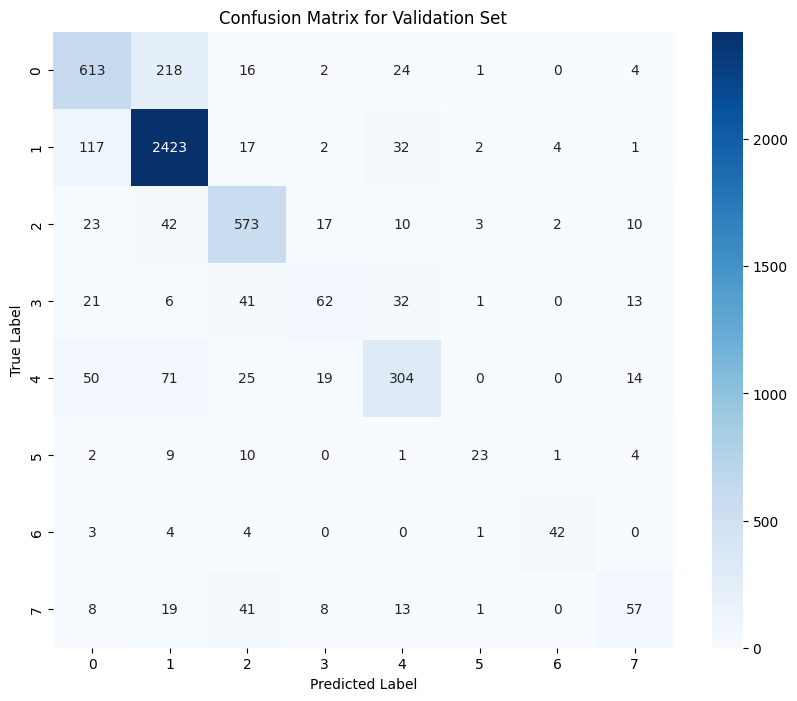

In [ ]:
# Load the trained model
model.load_state_dict(torch.load('best_vmamba_model_lowest_loss.pth'))

def evaluate(model, dataloader, criterion=None, is_test=False):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    all_probs = []
    num_classes = 9

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Extract logits from the model output dictionary
            logits = outputs.logits if hasattr(outputs, "logits") else outputs["logits"]
            probs = torch.softmax(logits, dim=-1)

            if is_test:
                max_probs, predicted = probs.max(1)
                unk_probs = 1 - max_probs
                predicted = torch.where(unk_probs > 0.5,
                                        torch.tensor(num_classes-1).to(device),
                                        predicted)
            else:
                _, predicted = probs.max(1)

            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return 100. * correct / total, all_preds, all_labels, all_probs

# Evaluate the model on the validation set
final_val_acc, val_preds, val_labels, _ = evaluate(model, val_loader, criterion=None)

# Print final validation accuracy
print(f'Final Validation Accuracy: {final_val_acc:.2f}%')

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Testing before last training on combined dataset


Evaluating on test set (ignoring UNK class)...
Test Accuracy (excluding UNK): 72.25%
F1 Score (excluding UNK): 0.7105


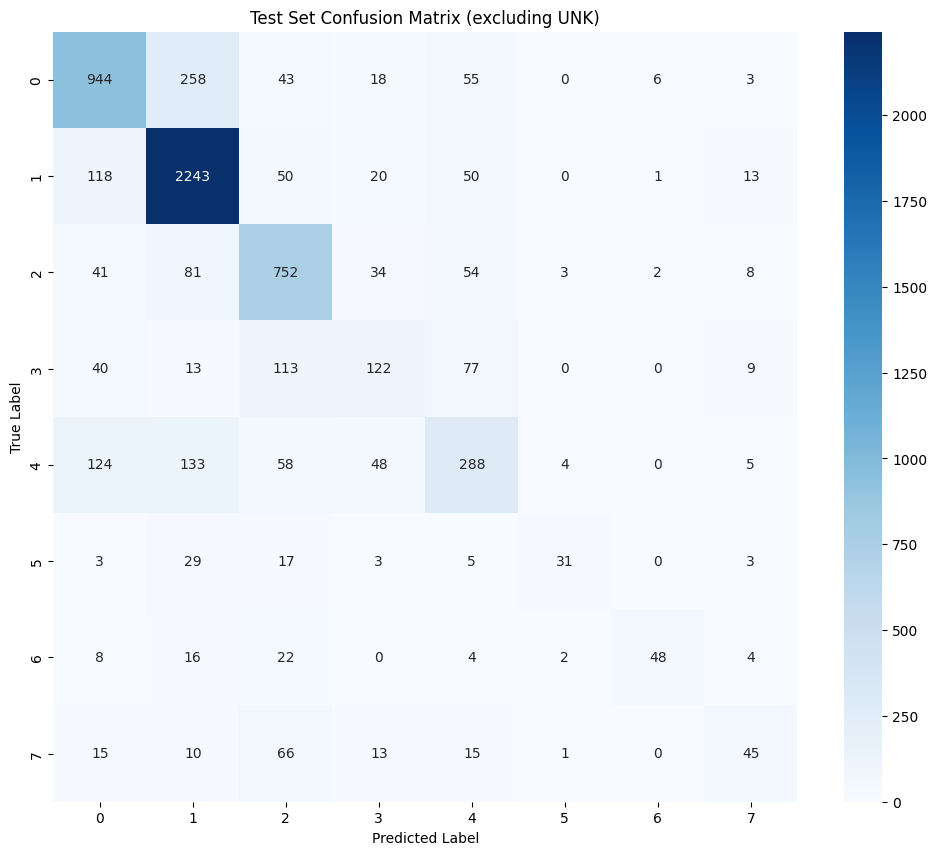

Displaying first 1718 misclassified images:


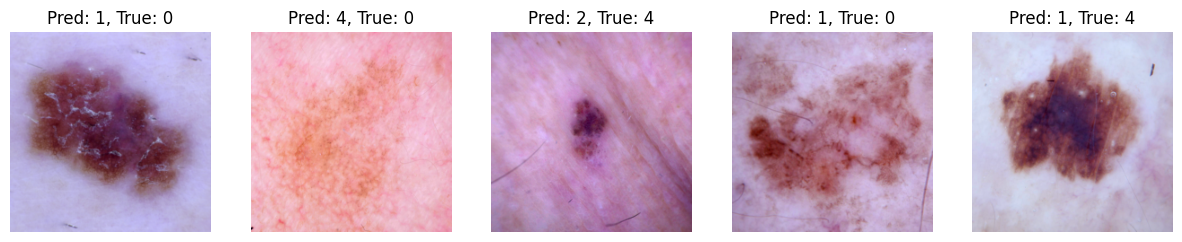

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Load the trained model
model.load_state_dict(torch.load('best_vmamba_model_lowest_loss.pth'))
# model.load_state_dict(torch.load('best_vmamba_model_after_val.pth'))

def evaluate_ignore_unk(model, dataloader):
    """
    Evaluates the model on test set, ignoring samples that are labeled as UNK class.
    Works with a model trained on 9 classes but only evaluates on the first 8 classes.
    """
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    all_probs = []
    misclassified_images = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Skip samples labeled as UNK (class 8)
            mask = targets != 8
            if not mask.any():
                continue

            # Filter out UNK samples
            filtered_inputs = inputs[mask]
            filtered_targets = targets[mask]

            if len(filtered_inputs) == 0:
                continue

            outputs = model(filtered_inputs)
            # Extract logits from the model output dictionary
            logits = outputs.logits if hasattr(outputs, "logits") else outputs["logits"]
            probs = torch.softmax(logits, dim=-1)

            # Only consider probabilities for known classes (0-7)
            known_probs = probs[:, :8]
            _, predicted = known_probs.max(1)

            correct += predicted.eq(filtered_targets).sum().item()
            total += filtered_targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(filtered_targets.cpu().numpy())
            all_probs.extend(known_probs.cpu().numpy())

            # Collect misclassified images for visualization
            for i in range(len(filtered_targets)):
                if predicted[i] != filtered_targets[i]:
                    misclassified_images.append((filtered_inputs[i].cpu(), predicted[i].cpu(), filtered_targets[i].cpu()))

    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy, all_preds, all_labels, all_probs, misclassified_images

# After training loop, evaluate ignoring UNK class
print("\nEvaluating on test set (ignoring UNK class)...")
test_acc, test_preds, test_labels, test_probs, misclassified_images = evaluate_ignore_unk(model, test_loader)
print(f'Test Accuracy (excluding UNK): {test_acc:.2f}%')

# Calculate F1 Score (using weighted average)
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'F1 Score (excluding UNK): {f1:.4f}')

# Calculate and display confusion matrix for test set (8 classes)
cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix (excluding UNK)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display some misclassified images
print(f"Displaying first {len(misclassified_images)} misclassified images:")
num_images = 5  # Change this to display more or fewer images
plt.figure(figsize=(15, 10))

for i, (image, pred, true) in enumerate(misclassified_images[:num_images]):
    plt.subplot(1, num_images, i + 1)

    # If the image tensor is in format [C, H, W], permute it to [H, W, C]
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format (if necessary)

    # Ensure the image is in the right range for plotting
    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

    plt.imshow(image)
    plt.title(f"Pred: {pred}, True: {true}")
    plt.axis('off')

plt.show()


# Save test predictions (excluding UNK)
test_results = pd.DataFrame({
    'image': [test_ground_truth_df['image'][i] for i, label in enumerate(test_labels) if label != 8],
    'predicted_class': test_preds,
    'true_class': test_labels
})
test_results.to_csv('test_predictions_no_unk.csv', index=False)


## Last Training with Val + Train:

In [ ]:
# === Combine the Training and Validation Data ===
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])  # Combine train and val datasets
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# === Fine-Tune on Combined Dataset ===
num_fine_tune_epochs = 5  # Fine-tune for a few epochs with the combined dataset
for epoch in range(num_fine_tune_epochs):
    print(f'\nFine-tuning Epoch [{epoch+1}/{num_fine_tune_epochs}]')
    train_acc, train_loss = train_one_epoch(model, combined_loader, optimizer, criterion=FocalLoss(gamma=2.0, reduction='mean'))
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Train Loss: {train_loss:.4f}')

torch.save(model.state_dict(), 'best_vmamba_model_after_val.pth')
# print(f'✅ Model saved! Best Macro F1: {best_val_f1:.4f}')


Fine-tuning Epoch [1/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 78.42%
Train Loss: 0.4147

Fine-tuning Epoch [2/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 79.10%
Train Loss: 0.3710

Fine-tuning Epoch [3/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 80.72%
Train Loss: 0.3357

Fine-tuning Epoch [4/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 81.10%
Train Loss: 0.3032

Fine-tuning Epoch [5/5]


Train:   0%|          | 0/396 [00:00<?, ?it/s]

Train Accuracy: 82.61%
Train Loss: 0.2700


## Testing after last training on combined dataset


Evaluating on test set (ignoring UNK class)...
Test Accuracy (excluding UNK): 73.51%
F1 Score (excluding UNK): 0.7278


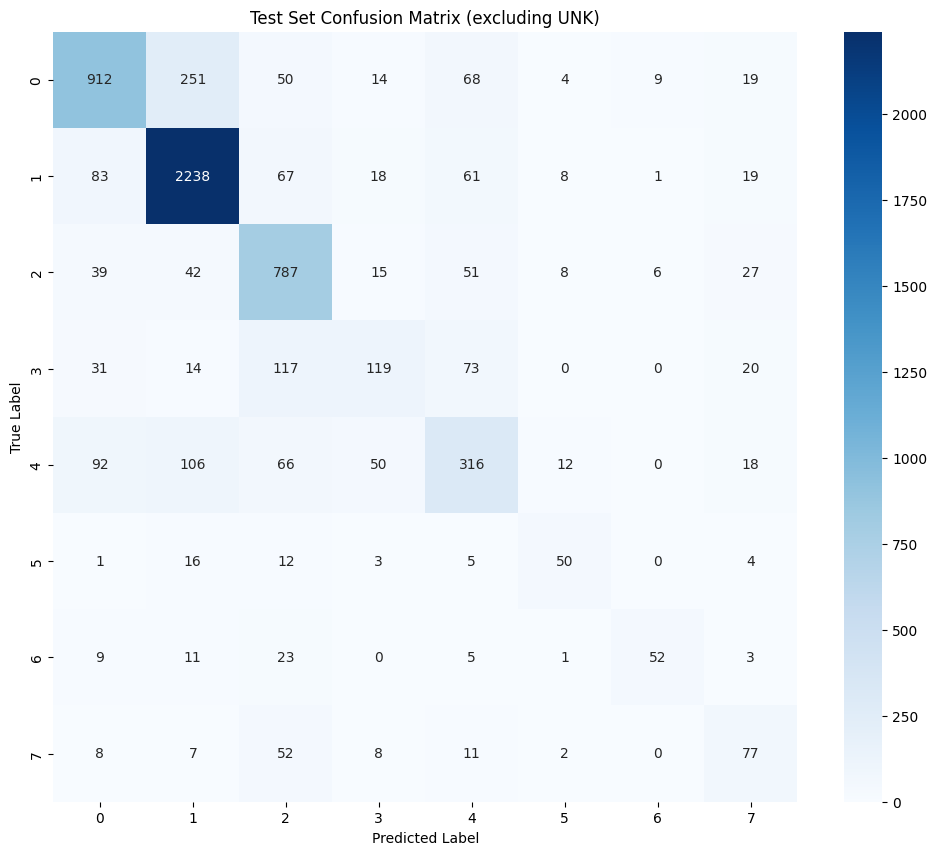

Displaying first 1640 misclassified images:


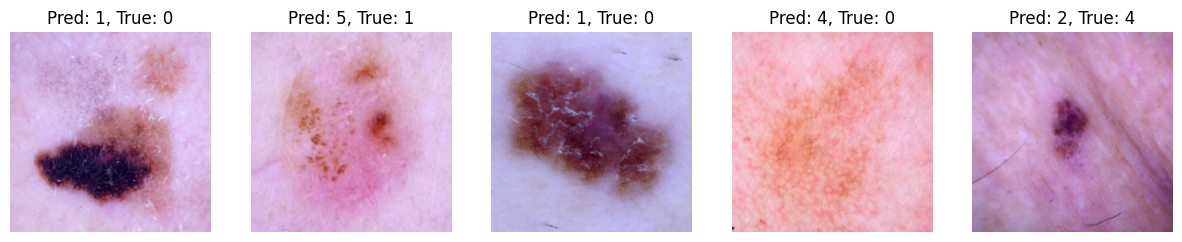

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Load the trained model
# model.load_state_dict(torch.load('best_vmamba_model_lowest_loss.pth'))
model.load_state_dict(torch.load('best_vmamba_model_after_val.pth'))

def evaluate_ignore_unk(model, dataloader):
    """
    Evaluates the model on test set, ignoring samples that are labeled as UNK class.
    Works with a model trained on 9 classes but only evaluates on the first 8 classes.
    """
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    all_probs = []
    misclassified_images = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Skip samples labeled as UNK (class 8)
            mask = targets != 8
            if not mask.any():
                continue

            # Filter out UNK samples
            filtered_inputs = inputs[mask]
            filtered_targets = targets[mask]

            if len(filtered_inputs) == 0:
                continue

            outputs = model(filtered_inputs)
            # Extract logits from the model output dictionary
            logits = outputs.logits if hasattr(outputs, "logits") else outputs["logits"]
            probs = torch.softmax(logits, dim=-1)

            # Only consider probabilities for known classes (0-7)
            known_probs = probs[:, :8]
            _, predicted = known_probs.max(1)

            correct += predicted.eq(filtered_targets).sum().item()
            total += filtered_targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(filtered_targets.cpu().numpy())
            all_probs.extend(known_probs.cpu().numpy())

            # Collect misclassified images for visualization
            for i in range(len(filtered_targets)):
                if predicted[i] != filtered_targets[i]:
                    misclassified_images.append((filtered_inputs[i].cpu(), predicted[i].cpu(), filtered_targets[i].cpu()))

    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy, all_preds, all_labels, all_probs, misclassified_images

# After training loop, evaluate ignoring UNK class
print("\nEvaluating on test set (ignoring UNK class)...")
test_acc, test_preds, test_labels, test_probs, misclassified_images = evaluate_ignore_unk(model, test_loader)
print(f'Test Accuracy (excluding UNK): {test_acc:.2f}%')

# Calculate F1 Score (using weighted average)
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'F1 Score (excluding UNK): {f1:.4f}')

# Calculate and display confusion matrix for test set (8 classes)
cm_test = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix (excluding UNK)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display some misclassified images
print(f"Displaying first {len(misclassified_images)} misclassified images:")
num_images = 5  # Change this to display more or fewer images
plt.figure(figsize=(15, 10))

for i, (image, pred, true) in enumerate(misclassified_images[:num_images]):
    plt.subplot(1, num_images, i + 1)

    # If the image tensor is in format [C, H, W], permute it to [H, W, C]
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format (if necessary)

    # Ensure the image is in the right range for plotting
    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

    plt.imshow(image)
    plt.title(f"Pred: {pred}, True: {true}")
    plt.axis('off')

plt.show()


# Save test predictions (excluding UNK)
test_results = pd.DataFrame({
    'image': [test_ground_truth_df['image'][i] for i, label in enumerate(test_labels) if label != 8],
    'predicted_class': test_preds,
    'true_class': test_labels
})
test_results.to_csv('test_predictions_no_unk.csv', index=False)


In [ ]:
from google.colab import files
files.download("best_vmamba_model_after_val.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Ensemble:

In [ ]:
from transformers import AutoModelForImageClassification
import timm

# Load all models
model1 = AutoModelForImageClassification.from_pretrained(
    "nvidia/MambaVision-B-21K",
    trust_remote_code=True
).to(device)
model2 = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=8).to(device)

model1.load_state_dict(torch.load('mambavision_AdamW_afterval.pth'))
model2.load_state_dict(torch.load('best_vit_model_7121.pth'))

model1.eval()
model2.eval()

from tqdm import tqdm

def evaluate_ensemble_ignore_unk(model1, model2, dataloader, weights=(0.5, 0.5)):
    model1.eval()
    model2.eval()

    all_preds, all_labels, all_probs = [], [], []
    correct, total = 0, 0
    misclassified_images = []

    for inputs, targets in tqdm(dataloader, desc="Evaluating"):
        inputs, targets = inputs.to(device), targets.to(device)

        mask = targets != 8  # Exclude UNK class
        if not mask.any():
            continue

        filtered_inputs = inputs[mask]
        filtered_targets = targets[mask]

        if len(filtered_inputs) == 0:
            continue

        # Forward pass through both models
        out1 = model1(filtered_inputs)
        out2 = model2(filtered_inputs)

        # Extract logits safely
        logits1 = out1.logits if hasattr(out1, "logits") else out1["logits"] if isinstance(out1, dict) else out1
        logits2 = out2.logits if hasattr(out2, "logits") else out2["logits"] if isinstance(out2, dict) else out2

        # Compute softmax and limit to first 8 classes
        probs1 = torch.softmax(logits1[:, :8], dim=-1)
        probs2 = torch.softmax(logits2[:, :8], dim=-1)

        # Weighted average
        avg_probs = weights[0] * probs1 + weights[1] * probs2
        _, predicted = avg_probs.max(1)

        correct += predicted.eq(filtered_targets).sum().item()
        total += filtered_targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(filtered_targets.cpu().numpy())
        all_probs.extend(avg_probs.detach().cpu().numpy())


        for i in range(len(filtered_targets)):
            if predicted[i] != filtered_targets[i]:
                misclassified_images.append((filtered_inputs[i].cpu(), predicted[i].cpu(), filtered_targets[i].cpu()))

    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy, all_preds, all_labels, all_probs, misclassified_images

def evaluate_ensemble_most_confident(model1, model2, dataloader):
    model1.eval()
    model2.eval()

    all_preds, all_labels, all_probs = [], [], []
    correct, total = 0, 0
    misclassified_images = []

    for inputs, targets in tqdm(dataloader, desc="Evaluating"):
        inputs, targets = inputs.to(device), targets.to(device)

        mask = targets != 8  # Exclude UNK class
        if not mask.any():
            continue

        filtered_inputs = inputs[mask]
        filtered_targets = targets[mask]

        if len(filtered_inputs) == 0:
            continue

        # Forward pass
        out1 = model1(filtered_inputs)
        out2 = model2(filtered_inputs)

        # Extract logits
        logits1 = out1.logits if hasattr(out1, "logits") else out1["logits"] if isinstance(out1, dict) else out1
        logits2 = out2.logits if hasattr(out2, "logits") else out2["logits"] if isinstance(out2, dict) else out2

        # Compute softmax and truncate to 8 classes
        probs1 = torch.softmax(logits1[:, :8], dim=-1)
        probs2 = torch.softmax(logits2[:, :8], dim=-1)

        # Pick prediction from the most confident model for each sample
        max_conf1, preds1 = probs1.max(dim=1)
        max_conf2, preds2 = probs2.max(dim=1)

        # Decide per sample which model to trust more
        final_preds = torch.where(max_conf1 > max_conf2, preds1, preds2)
        final_probs = torch.where(max_conf1[:, None] > max_conf2[:, None], probs1, probs2)

        correct += final_preds.eq(filtered_targets).sum().item()
        total += filtered_targets.size(0)
        all_preds.extend(final_preds.cpu().numpy())
        all_labels.extend(filtered_targets.cpu().numpy())
        all_probs.extend(final_probs.detach().cpu().numpy())

        for i in range(len(filtered_targets)):
            if final_preds[i] != filtered_targets[i]:
                misclassified_images.append((filtered_inputs[i].cpu(), final_preds[i].cpu(), filtered_targets[i].cpu()))

    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy, all_preds, all_labels, all_probs, misclassified_images


test_acc, test_preds, test_labels, test_probs, misclassified_images = evaluate_ensemble_ignore_unk(model1, model2, test_loader)
#test_acc, test_preds, test_labels, test_probs, misclassified_images = evaluate_ensemble_most_confident(model1, model2, test_loader)


print(f'Ensembled Test Accuracy (excluding UNK): {test_acc:.2f}%')
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'Ensembled F1 Score (excluding UNK): {f1:.4f}')

from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(test_labels, test_preds)
print(f'Normalized Multi-Class Accuracy (Balanced Accuracy): {balanced_acc:.4f}')

from sklearn.metrics import roc_auc_score
import numpy as np

# Convert labels to one-hot encoding
num_classes = 8
true_one_hot = np.eye(num_classes)[test_labels]

# Convert predicted probabilities to numpy array
test_probs_np = np.array(test_probs)

# Compute AUC
auc_score = roc_auc_score(true_one_hot, test_probs_np, multi_class='ovr', average='macro')
print(f'Multi-class AUC Score (OvR, Macro Avg): {auc_score:.4f}')


test_results = pd.DataFrame({
    'image': [test_ground_truth_df['image'][i] for i, label in enumerate(test_labels)],
    'predicted_class': test_preds,
    'true_class': test_labels
})
test_results.to_csv('ensemble_test_predictions_no_unk.csv', index=False)


Evaluating:   0%|          | 0/515 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 515/515 [02:53<00:00,  2.96it/s]

Ensembled Test Accuracy (excluding UNK): 73.33%
Ensembled F1 Score (excluding UNK): 0.7287
Normalized Multi-Class Accuracy (Balanced Accuracy): 0.5941
Multi-class AUC Score (OvR, Macro Avg): 0.9245


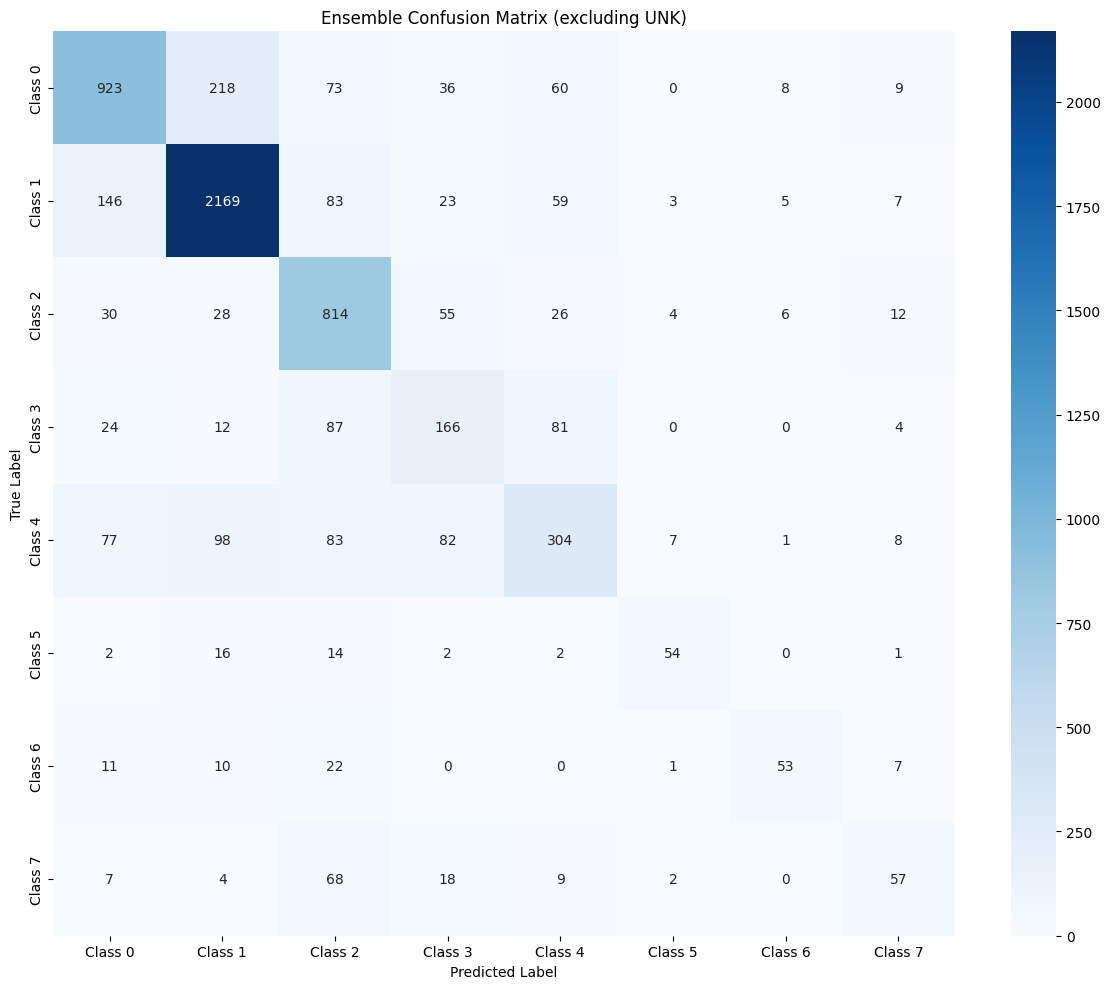

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm_ensemble = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(8)],
            yticklabels=[f'Class {i}' for i in range(8)])
plt.title('Ensemble Confusion Matrix (excluding UNK)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# With TTA

In [ ]:
!pip install ttach

In [ ]:
import ttach as tta

# Define test time augmentations (TTA) for testing phase with random flips and resize
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 90, 180, 270]),
    ]
)
import torchvision.transforms as T

tta_transforms = [
    T.Compose([T.RandomRotation(degrees=10)]),            # Rotate by up to 30 degrees
    #T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2)]),  # Color jitter
    #T.Compose([T.Resize((224, 224))]),
]


def tta_ensemble_predict(models, inputs):
    """
    Applies TTA to each model and averages both within-model and across-model probabilities.
    """
    model_probs = []
    for model in models:
        tta_preds = []
        for tta_transform in tta_transforms:
            augmented_inputs = torch.stack([tta_transform(img.cpu()) for img in inputs])
            augmented_inputs = augmented_inputs.to(device)
            with torch.no_grad():
                outputs = model(augmented_inputs)
                probs = torch.softmax(outputs[:, :8], dim=-1)  # Limit to known classes
                tta_preds.append(probs)
        avg_model_probs = torch.mean(torch.stack(tta_preds), dim=0)
        model_probs.append(avg_model_probs)

    # Average across models
    final_probs = torch.mean(torch.stack(model_probs), dim=0)
    return final_probs

def evaluate_wrapped_ensemble(models, dataloader):
    for model in models:
        model.eval()

    all_preds, all_labels, all_probs = [], [], []
    correct, total = 0, 0
    misclassified_images = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating (TTA-Wrapped + Ensemble)"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Skip UNK class
            mask = targets != 8
            if not mask.any():
                continue

            filtered_inputs = inputs[mask]
            filtered_targets = targets[mask]

            if len(filtered_inputs) == 0:
                continue

            model_probs = []
            for model in models:
                outputs = model(filtered_inputs)
                probs = torch.softmax(outputs[:, :8], dim=-1)  # Only use known classes
                model_probs.append(probs)

            # Average predictions from all models
            avg_probs = torch.mean(torch.stack(model_probs), dim=0)
            _, predicted = avg_probs.max(1)

            correct += predicted.eq(filtered_targets).sum().item()
            total += filtered_targets.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(filtered_targets.cpu().numpy())
            all_probs.extend(avg_probs.detach().cpu().numpy())

            for i in range(len(filtered_targets)):
                if predicted[i] != filtered_targets[i]:
                    misclassified_images.append((filtered_inputs[i].cpu(), predicted[i].cpu(), filtered_targets[i].cpu()))

    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy, all_preds, all_labels, all_probs, misclassified_images



In [ ]:
import torch.nn as nn

class LogitsOnlyModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        # Support both dict and object with .logits
        if isinstance(out, dict):
            return out["logits"]
        elif hasattr(out, "logits"):
            return out.logits
        else:
            return out  # assume it's already a tensor

tta_transforms = tta.aliases.d4_transform()

# Wrap models
wrapped_model1 = tta.ClassificationTTAWrapper(LogitsOnlyModel(model1), tta_transforms)
wrapped_model2 = tta.ClassificationTTAWrapper(LogitsOnlyModel(model2), tta_transforms)

models = [wrapped_model1, wrapped_model2]

test_acc, test_preds, test_labels, test_probs, misclassified_images = evaluate_wrapped_ensemble([wrapped_model1, wrapped_model2], test_loader)
print(f"TTA-Ensembled Accuracy: {test_acc:.2f}%")

f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'Ensembled F1 Score (excluding UNK): {f1:.4f}')

from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(test_labels, test_preds)
print(f'Normalized Multi-Class Accuracy (Balanced Accuracy): {balanced_acc:.4f}')

from sklearn.metrics import roc_auc_score
import numpy as np

# Convert labels to one-hot encoding
num_classes = 8
true_one_hot = np.eye(num_classes)[test_labels]

# Convert predicted probabilities to numpy array
test_probs_np = np.array(test_probs)

# Compute AUC
auc_score = roc_auc_score(true_one_hot, test_probs_np, multi_class='ovr', average='macro')
print(f'Multi-class AUC Score (OvR, Macro Avg): {auc_score:.4f}')


test_results = pd.DataFrame({
    'image': [test_ground_truth_df['image'][i] for i, label in enumerate(test_labels)],
    'predicted_class': test_preds,
    'true_class': test_labels
})
test_results.to_csv('ensemble_test_predictions_no_unk.csv', index=False)

Evaluating (TTA-Wrapped + Ensemble): 100%|██████████| 515/515 [17:33<00:00,  2.05s/it]

TTA-Ensembled Accuracy: 74.27%
Ensembled F1 Score (excluding UNK): 0.7380
Normalized Multi-Class Accuracy (Balanced Accuracy): 0.6109
Multi-class AUC Score (OvR, Macro Avg): 0.9441


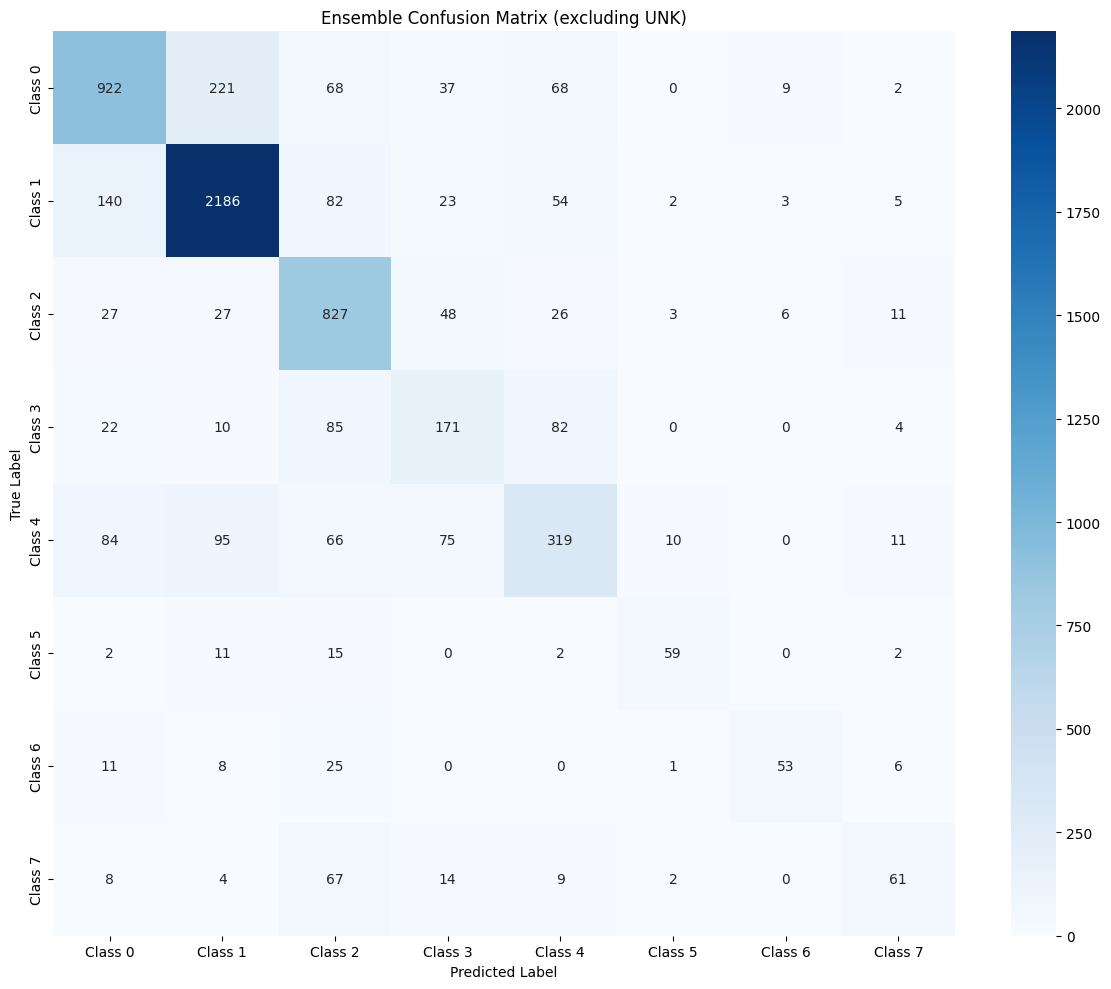

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm_ensemble = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(8)],
            yticklabels=[f'Class {i}' for i in range(8)])
plt.title('Ensemble Confusion Matrix (excluding UNK)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
